In [8]:
# import packages
import pandas as pd
import os
import csv
import numpy as np
import gensim
import gensim.corpora as corpora
from gensim.models import ldaseqmodel
import time
from gensim.models.wrappers import DtmModel
import pickle
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [9]:
# read in csv file
all_data = pd.read_csv('./all_data.csv', header=None)
# add columns
all_data.columns = ["year", "title", "article"]
# sort by year
all_data = all_data.sort_values(by=['year'])
# change index
new_index = np.arange(0, len(all_data))
all_data["new_index"] = new_index
all_data = all_data.set_index('new_index')

In [10]:
# construct the stop word list
stopwords = [line.strip() for line in open("stop_words_copy2.txt",encoding='UTF-8').readlines()]

In [11]:
# construct the function that preprocess the text
def preprocess(text):
    '''
    Preprocess the text by tokenizing the string into uni-grams, deleting all 
    numbers, punctuations and stop words. Store the preprocessed sting into 
    a list of words
    
    input: 
        text: text for preprocessing(str)
    output: a list of words
    '''
    result = []
    tokens = gensim.utils.tokenize(text)
    tokens_lst = list(tokens)
    for token in tokens_lst:
        if token not in stopwords:
            result.append(token)
            
    return result

In [12]:
# preprocess the data
processed_df = all_data['article'].map(preprocess)

In [13]:
# prepare Document-Term Matrix for the DTA model 
# Create Dictionaries for unique word counts of each decade
dic_all = corpora.Dictionary(processed_df)

# Create Corpus: Term Document Frequency
corpus_all = [dic_all.doc2bow(text) for text in processed_df]

In [14]:
# set the time slice
all_data[all_data['year']==1958]
# before 60s: 0-35
all_data[all_data['year']==1978]
# before 1979: 36-70
all_data[all_data['year']==1989]
# before 1990: 71-876
all_data[all_data['year']==2003]
# before 2003: 877-1811
time_slice = [71, 806, 935]

In [8]:
# fit the 7-topic model
start = time.time()
ldaseq_7 = ldaseqmodel.LdaSeqModel(corpus=corpus_all, id2word=dic_all, time_slice=time_slice, 
                                    num_topics=7, chain_variance=0.1, random_state=100)
end = time.time()
print(end - start)

/Users/ditong/anaconda3/lib/python3.6/site-packages/gensim/models/ldaseqmodel.py:230: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


7919.340847015381


In [9]:
# save model
pickle.dump(ldaseq_7, open("ldaseq_model_7.sav", 'wb'))
# check
loaded_model_7 = pickle.load(open("ldaseq_model_7.sav", 'rb'))

In [27]:
# calculate coherence matrix
topics_dtm_7 = loaded_model_7.dtm_coherence(time=0)
cm_DTM_7 = CoherenceModel(topics=topics_dtm_7, corpus=corpus_all, dictionary=dic_all, coherence='u_mass')
print ("U_mass topic coherence")
print ("DTM Python coherence is", cm_DTM_7.get_coherence())

U_mass topic coherence
DTM Python coherence is -1.2957071265665625


In [23]:
doc_0 = ldaseq_7.doc_topics(0) # check the 558th document in the corpuses topic distribution
print (doc_0)

[4.62812977e-05 1.33966663e-01 4.62812977e-05 7.09583781e-03
 8.58752374e-01 4.62812977e-05 4.62812977e-05]


In [24]:
doc_0 = ldaseq_7.doc_topics(2) # check the 558th document in the corpuses topic distribution
print (doc_0)

[1.56968622e-05 1.56968622e-05 8.10891831e-03 1.65481129e-02
 8.70874926e-01 1.04420952e-01 1.56968622e-05]


In [17]:
doc_lst = []
doc_lst.append(doc_1)
doc_lst.append(doc_2)

In [18]:
doc_lst

[array([1.17550253e-04, 1.17550253e-04, 1.17550253e-04, 1.17550253e-04,
        8.64472923e-01, 1.34939326e-01, 1.17550253e-04]),
 array([1.56968622e-05, 1.56968622e-05, 8.10891831e-03, 1.65481129e-02,
        8.70874926e-01, 1.04420952e-01, 1.56968622e-05])]

In [19]:
trial_df = pd.DataFrame(doc_lst, columns=['t1', 't2', 't3', 't4', 't5', 't6', 't7'])

In [15]:
# check
loaded_model_7 = pickle.load(open("ldaseq_model_7.sav", 'rb'))

In [16]:
doc_topic_7 = []
for doc_num in range(len(all_data)):
    doc = loaded_model_7.doc_topics(doc_num)
    doc_topic_7.append(doc)
trial_df = pd.DataFrame(doc_topic_7, columns=['t1', 't2', 't3', 't4', 't5', 't6', 't7'])

In [17]:
trial_com_df = pd.concat([all_data, trial_df], axis=1, sort=False)

In [18]:
grouped_df = trial_com_df.groupby(['year']).sum().reset_index()

In [47]:
year_lst = grouped_df.index.tolist()

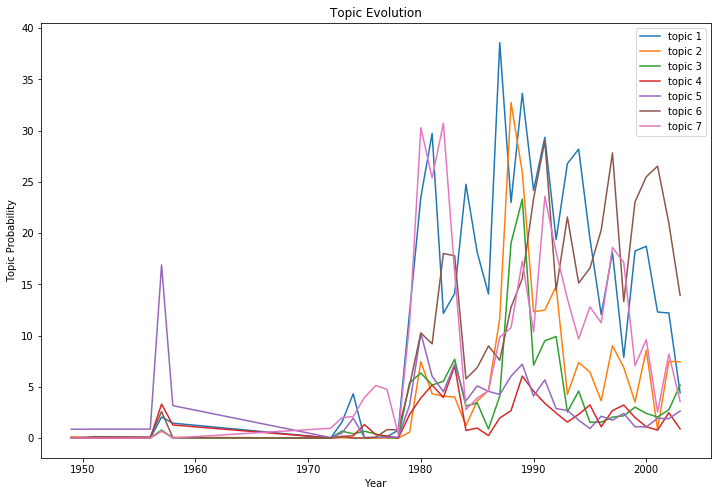

In [19]:
plt.figure(figsize=(12, 8))
plt.plot(grouped_df['year'], grouped_df['t1'], label='topic 1')
plt.plot(grouped_df['year'], grouped_df['t2'], label='topic 2')
plt.plot(grouped_df['year'], grouped_df['t3'], label='topic 3')
plt.plot(grouped_df['year'], grouped_df['t4'], label='topic 4')
plt.plot(grouped_df['year'], grouped_df['t5'], label='topic 5')
plt.plot(grouped_df['year'], grouped_df['t6'], label='topic 6')
plt.plot(grouped_df['year'], grouped_df['t7'], label='topic 7')
plt.title("Topic Evolution")
plt.xlabel("Year")
plt.ylabel("Topic Probability")
plt.legend(loc='best')
plt.show()

In [20]:
# print the first period (pre 1979)
first_period = loaded_model_7.print_topics(time=0)
first_period

[[('人口', 0.07807467267315431),
  ('我国', 0.020664044507026462),
  ('问题', 0.020076334925367173),
  ('发展', 0.017234139709424272),
  ('增长', 0.014542576864075677),
  ('国家', 0.013695840744934408),
  ('人民', 0.013139181279546453),
  ('世界', 0.012085342182386135),
  ('经济', 0.011423265324155612),
  ('中国', 0.009961251641259116),
  ('社会', 0.008673902424738204),
  ('会议', 0.008672924135181679),
  ('人', 0.00866027652630851),
  ('生产', 0.0073236846425224775),
  ('政策', 0.006673336207777895),
  ('解决', 0.006642455026714116),
  ('新', 0.006057960433014245),
  ('代表', 0.005409364405136563),
  ('速度', 0.005348424980312585),
  ('劳动力', 0.0051711715567284)],
 [('人口', 0.05400993865895189),
  ('城市', 0.02503688768247742),
  ('计划生育', 0.013973843839796635),
  ('人', 0.013880370575843322),
  ('工作', 0.011469844678253883),
  ('出生', 0.010840285205787378),
  ('生育', 0.010543638054943735),
  ('万', 0.0076864356201402),
  ('流动', 0.0064088727615562256),
  ('管理', 0.006272904088667081),
  ('岁', 0.006198615233553482),
  ('统计', 0.0058

In [21]:
# print the second period
# print topics of the second time period (1980s)
second_period = loaded_model_7.print_topics(time=1)
second_period

[[('人口', 0.07725142643540507),
  ('增长', 0.0185600253871004),
  ('发展', 0.015491018729791401),
  ('我国', 0.011567511033061445),
  ('问题', 0.011507455229249725),
  ('中国', 0.01131067289480227),
  ('国家', 0.0099297900680622),
  ('世界', 0.009552630455746119),
  ('控制', 0.009118818153838195),
  ('经济', 0.009005944176580374),
  ('人', 0.007263802543703053),
  ('亿', 0.00659796224356259),
  ('社会', 0.0065112632609655805),
  ('政策', 0.005535439062113943),
  ('增加', 0.005004195619216762),
  ('增长率', 0.004700621935164739),
  ('联合国', 0.004433503132520619),
  ('亚洲', 0.004161696430828734),
  ('生产', 0.004120231081372608),
  ('会议', 0.003980386673491332)],
 [('计划生育', 0.024734463510650315),
  ('人口', 0.02169382841374447),
  ('生育', 0.014757337986719328),
  ('人', 0.01307103449619486),
  ('万', 0.01119955460877787),
  ('工作', 0.010942889639533288),
  ('出生', 0.008820676964930527),
  ('岁', 0.00845564534056011),
  ('流动', 0.0077606159208397215),
  ('管理', 0.007584211365469063),
  ('妇女', 0.006316461600110603),
  ('部门', 0.005384

In [23]:
# print topics of the third time period (1990s)
third_period = loaded_model_7.print_topics(time=2)
third_period

[[('人口', 0.07230205980280645),
  ('发展', 0.022030920952458885),
  ('增长', 0.014567730432559005),
  ('中国', 0.013794719390514089),
  ('问题', 0.011138359582381466),
  ('经济', 0.010941440091578295),
  ('世界', 0.010587344077030538),
  ('社会', 0.009986196914080198),
  ('我国', 0.009396068003904568),
  ('亿', 0.009263534201291541),
  ('控制', 0.008162603916930734),
  ('国际', 0.0076296316213129945),
  ('人', 0.006554988560380804),
  ('国家', 0.006514573910136968),
  ('水平', 0.005438284276981271),
  ('提高', 0.005110812909014424),
  ('持续', 0.004504164438773811),
  ('环境', 0.004366612496733019),
  ('联合国', 0.00429185134574813),
  ('资源', 0.004170892627892117)],
 [('人口', 0.03260990704211993),
  ('流动', 0.014820412620969567),
  ('计划生育', 0.014817864412387763),
  ('管理', 0.012769507921909246),
  ('工作', 0.012458454859257506),
  ('人', 0.012108348858428378),
  ('普查', 0.008817604099005944),
  ('生育', 0.008477451107236788),
  ('万', 0.008420547949706073),
  ('出生', 0.0077084578469213995),
  ('服务', 0.006854862750298761),
  ('全国', 